In [1]:
import glob
from collections import deque
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

import utils

In [2]:
cameraData = utils.loadCameraData()

test_image = cv2.imread("test_images/test4.jpg")

In [3]:
class LaneLine:
    def __init__(self, cameraData):
        self.cameraData = cameraData
        # Set the width of the windows +/- margin
        self.window_margin = 100
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        self.left_lane = {}
        self.right_lane = {}
        self.left_coefficients = None
        self.right_coefficients = None
        self.left_coefficients_list = deque(maxlen=25)
        self.right_coefficients_list = deque(maxlen=25)
        
    def measure_curvature_pixels(self, left_coefficients, right_coefficients, y_values):
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(y_values)

        # Calculation of R_curve (radius of curvature)
        left_curverature = ((1 + (2*left_coefficients[0]*y_eval + left_coefficients[1])**2)**1.5) / np.absolute(2*left_coefficients[0])
        right_curverature = ((1 + (2*right_coefficients[0]*y_eval + right_coefficients[1])**2)**1.5) / np.absolute(2*right_coefficients[0])

        return left_curverature, right_curverature
    
    def measure_curvature_real_world(self, y_values):
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(y_values)
        
        left_coefficients_cr = np.polyfit(self.left_lane['y']*self.ym_per_pix, self.left_lane['x']*self.xm_per_pix, 2)
        right_coefficients_cr = np.polyfit(self.right_lane['y']*self.ym_per_pix, self.right_lane['x']*self.xm_per_pix, 2)

        # Calculation of R_curve (radius of curvature)
        left_curverature = ((1 + (2*left_coefficients_cr[0]*y_eval*self.ym_per_pix + left_coefficients_cr[1])**2)**1.5) / np.absolute(2*left_coefficients_cr[0])
        right_curverature = ((1 + (2*right_coefficients_cr[0]*y_eval*self.ym_per_pix + right_coefficients_cr[1])**2)**1.5) / np.absolute(2*right_coefficients_cr[0])

        return left_curverature, right_curverature
    
    def fit_polynomial(self, left_x, left_y, right_x, right_y, img_shape):    
        # coefficients from Ex: 2x² + 5x + 4 = [2, 5, 4]
        # np.polyfit finds the values that solves a n degree equation that describes the given points
        self.left_coefficients = np.polyfit(left_y, left_x, 2)
        self.right_coefficients = np.polyfit(right_y, right_x, 2)
        
        self.left_coefficients_list.append(self.left_coefficients)
        self.right_coefficients_list.append(self.right_coefficients)
        
        self.left_coefficients = np.mean(self.left_coefficients_list, axis=0)
        self.right_coefficients = np.mean(self.right_coefficients_list, axis=0)

        # generate y values to plot the lane line to later get x position and plot the line
        # Ex: f(y) = 2y² + 5y + 4. I'm here generating values for y
        # This function generate img_shape.shape[0](720) values from [0, img_shape.shape[0]-1(719)]
        y_values = np.linspace(0, img_shape[0]-1, img_shape[0])

        # get the x values from the y values previsiously generated
        left_x_values  = self.left_coefficients[0] * y_values**2 + self.left_coefficients[1] * y_values + self.left_coefficients[2]
        right_x_values = self.right_coefficients[0] * y_values**2 + self.right_coefficients[1] * y_values + self.right_coefficients[2]

        return left_x_values, right_x_values, y_values
    
    def find_lane_sliding_windows(self, warped):
        histogram = utils.hist(warped)

        midpoint = np.int(histogram.shape[0]//2)
        left_lane = {
            'base_point': np.argmax(histogram[:midpoint]),
        }
        right_lane = {
            'base_point': np.argmax(histogram[midpoint:]) + midpoint
        }

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        number_windows = 10
        # Height of windows - based on number_windows above and image shape
        window_height = np.int(warped.shape[0]//number_windows)
        # Set the minimum number of pixels that must be found. If not found, the window is recentered
        min_num_pix = 50

        # Current positions to be updated later for each window in nwindows
        left_lane['current_point']  = left_lane['base_point']
        right_lane['current_point'] = right_lane['base_point']

        # Create empty lists to receive left and right lane pixel indices
        left_lane['indices'] = []
        right_lane['indices'] = []

        # Step through the windows one by one
        for idx_window in range(number_windows):
            # Identify window boundaries in x and y (and right and left)
            left_lane['window'] = {
                'top':    warped.shape[0] - ((idx_window+1) * window_height),
                'bottom': warped.shape[0] - (idx_window * window_height),
                'left':   left_lane['current_point'] - self.window_margin,
                'right':  left_lane['current_point'] + self.window_margin
            }
            right_lane['window'] = {
                'top':    warped.shape[0] - ((idx_window+1) * window_height),
                'bottom': warped.shape[0] - (idx_window * window_height),
                'left':   right_lane['current_point'] - self.window_margin,
                'right':  right_lane['current_point'] + self.window_margin,
            }

            # Identify the nonzero pixels in x and y within the window #
            # Doing that & operation, it's checked for every pixel if it is inside the window
            # It returns a array of indices of the pixels that is not zero on nonzero array
            left_lane['good_indices'] = (
                (self.non_zero_y < left_lane['window']['bottom']) &
                (self.non_zero_y >=  left_lane['window']['top'])  &
                (self.non_zero_x >= left_lane['window']['left'])  &
                (self.non_zero_x <  left_lane['window']['right'])
            ).nonzero()[0]

            right_lane['good_indices'] = (
                (self.non_zero_y < right_lane['window']['bottom']) &
                (self.non_zero_y >=  right_lane['window']['top']) &
                (self.non_zero_x >= right_lane['window']['left']) &
                (self.non_zero_x <  right_lane['window']['right'])
            ).nonzero()[0]

            teste = (
                (self.non_zero_y < left_lane['window']['bottom']) &
                (self.non_zero_y >=  left_lane['window']['top'])  &
                (self.non_zero_x >= left_lane['window']['left'])  &
                (self.non_zero_x <  left_lane['window']['right'])
            )

            left_lane['indices'].append(left_lane['good_indices'])
            right_lane['indices'].append(right_lane['good_indices'])

            if len(left_lane['good_indices']) > min_num_pix:
                left_lane['current_point']  = np.int(np.mean(self.non_zero_x[left_lane['good_indices']]))
            if len(right_lane['good_indices']) > min_num_pix:        
                right_lane['current_point'] = np.int(np.mean(self.non_zero_x[right_lane['good_indices']]))

        try:
            left_lane['indices'] = np.concatenate(left_lane['indices'])
            right_lane['indices'] = np.concatenate(right_lane['indices'])
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Save the points detected on every window to later fit a polynom 
        left_lane['x']  = self.non_zero_x[left_lane['indices']]
        left_lane['y']  = self.non_zero_y[left_lane['indices']]
        right_lane['x'] = self.non_zero_x[right_lane['indices']]
        right_lane['y'] = self.non_zero_y[right_lane['indices']]
        
        return left_lane, right_lane
    
    def search_around_poly(self, warped):
        left_lane, right_lane = {}, {}
        left_lane['indices'] = (
            (self.non_zero_x > (self.left_coefficients[0]*(self.non_zero_y**2) + 
                           self.left_coefficients[1]*self.non_zero_y + self.left_coefficients[2] - self.window_margin)) & 
            (self.non_zero_x < (self.left_coefficients[0]*(self.non_zero_y**2) + 
                           self.left_coefficients[1]*self.non_zero_y + self.left_coefficients[2] + self.window_margin))
        )
        right_lane['indices'] = (
            (self.non_zero_x > (self.right_coefficients[0]*(self.non_zero_y**2) + 
                           self.right_coefficients[1]*self.non_zero_y + self.right_coefficients[2] - self.window_margin)) & 
            (self.non_zero_x < (self.right_coefficients[0]*(self.non_zero_y**2) + 
                           self.right_coefficients[1]*self.non_zero_y + self.right_coefficients[2] + self.window_margin))
        )

        left_lane['x'] = self.non_zero_x[left_lane['indices']]
        left_lane['y'] = self.non_zero_y[left_lane['indices']]
        right_lane['x'] = self.non_zero_x[right_lane['indices']]
        right_lane['y'] = self.non_zero_y[right_lane['indices']]
        
        return left_lane, right_lane
    
    def detect(self, image, plot_warped=False, plot_unwarped=False, convertToRGB=False):
        if convertToRGB:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        warped = utils.find_edges_warped(image, self.cameraData)
        # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
        self.non_zero   = warped.nonzero()
        # X position of each pixel of the image that is not 0.
        # Ex:
        # [255, 0, 255] 
        # [0, 255, 255]
        # [0, 255, 255]
        # Output for non_zero_x = [0, 1, 1, 2, 2, 2]
        # REMEMBER: len(non_zero_x) is not the same as len(image) on x axis
        self.non_zero_y = np.array(self.non_zero[0])
        self.non_zero_x = np.array(self.non_zero[1])
        
        if self.left_coefficients is not None and self.right_coefficients is not None:
            self.left_lane, self.right_lane = self.search_around_poly(warped)
        else:
            self.left_lane, self.right_lane = self.find_lane_sliding_windows(warped)
            
        # Fit new polynomials
        left_x_values, right_x_values, y_values = self.fit_polynomial(self.left_lane['x'], self.left_lane['y'], 
                                                                       self.right_lane['x'], self.right_lane['y'], warped.shape)
        # Calculate the lane curvature
        #self.left_curverature, self.right_curverature = self.measure_curvature_pixels(self.left_coefficients, 
        #                                                                     self.right_coefficients, 
        #                                                                     y_values)
        self.left_curverature_rw, self.right_curverature_rw = self.measure_curvature_real_world(y_values)
        
        if self.left_curverature_rw < 100 or self.right_curverature_rw < 100:
            self.left_lane, self.right_lane = self.find_lane_sliding_windows(warped)
            # Fit new polynomials
            left_x_values, right_x_values, y_values = self.fit_polynomial(self.left_lane['x'], self.left_lane['y'], 
                                                                           self.right_lane['x'], self.right_lane['y'], warped.shape)            # Calculate the lane curvature
            self.left_curverature_rw, self.right_curverature_rw = self.measure_curvature_real_world(y_values)
        
        average_curve_rad = (self.left_curverature_rw + self.right_curverature_rw)/2
        curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
        
        # compute the offset from the center
        ## FIXX
        camera_position = image.shape[1]//2
        lane_center = (right_x_values[image.shape[0]-1] + left_x_values[image.shape[0]-1])/2
        center_offset_pixels = camera_position - lane_center
        center_offset_mtrs = self.xm_per_pix*center_offset_pixels
        offset_string = "Center offset: %.2f m" % center_offset_mtrs
        
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((warped, warped, warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[self.non_zero_y[self.left_lane['indices']], self.non_zero_x[self.left_lane['indices']]] = [255, 0, 0]
        out_img[self.non_zero_y[self.right_lane['indices']], self.non_zero_x[self.right_lane['indices']]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        self.left_lane['window1'] = np.array(
            [np.transpose(np.vstack([left_x_values-self.window_margin, y_values]))]
        )
        self.left_lane['window2'] = np.array(
            [np.flipud(np.transpose(np.vstack([left_x_values+self.window_margin, y_values])))]
        )
        self.left_lane['points']  = np.hstack((self.left_lane['window1'], self.left_lane['window2']))

        self.right_lane['window1'] = np.array(
            [np.transpose(np.vstack([right_x_values-self.window_margin, y_values]))]
        )
        self.right_lane['window2'] = np.array(
            [np.flipud(np.transpose(np.vstack([right_x_values+self.window_margin, y_values])))]
        )
        self.right_lane['points']  = np.hstack((self.right_lane['window1'], self.right_lane['window2']))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([self.left_lane['points']]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([self.right_lane['points']]), (0,255, 0))
        # Soma ponderada
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        if plot_warped:
            plt.figure(figsize=(15,15))
            plt.plot(left_x_values, y_values, color='yellow')
            plt.plot(right_x_values, y_values, color='yellow')
            plt.imshow(out_img)
            plt.show()
        
        ## Unwarp the image and plot the lane ##
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        color_warp[self.non_zero_y[self.left_lane['indices']], self.non_zero_x[self.left_lane['indices']]] = [255, 0, 0]
        color_warp[self.non_zero_y[self.right_lane['indices']], self.non_zero_x[self.right_lane['indices']]] = [0, 0, 255]

        # Recast the x and y points into usable format for cv2.fillPoly()
        self.left_lane['points'] = np.array([np.transpose(np.vstack([left_x_values, y_values]))])
        self.right_lane['points'] = np.array([np.flipud(np.transpose(np.vstack([right_x_values, y_values])))])
        pts = np.hstack((self.left_lane['points'], self.right_lane['points']))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = utils.undoPerspectiveTransformation(color_warp, self.cameraData)
        # Combine the result with the original image
        resultUnwarped = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        cv2.putText(resultUnwarped, curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
        cv2.putText(resultUnwarped, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
        
        if plot_unwarped:
            plt.figure(figsize=(15,15))
            plt.imshow(resultUnwarped)
            plt.show()
        ## End visualization steps ##
        
        #return result, resultUnwarped
        return resultUnwarped

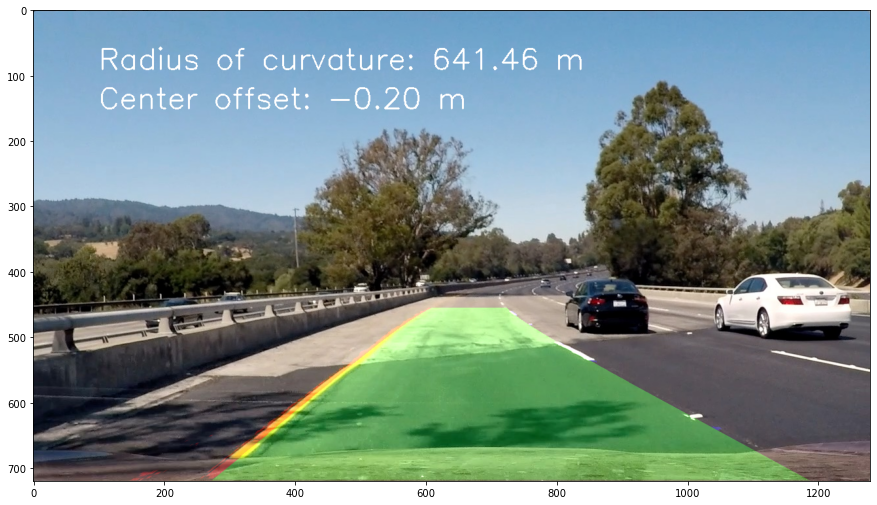

In [4]:
lane_line = LaneLine(cameraData)
out_img = lane_line.detect(test_image, plot_warped=False, plot_unwarped=True, convertToRGB=True)

In [5]:
# Convert to video
video_output = 'project_video_output.mp4'

# The file referenced in clip1 is the original video before anything has 
# been done to it
clip1 = VideoFileClip('project_video.mp4')

# NOTE: this function expects color images
video_clip = clip1.fl_image(lambda image: lane_line.detect(image))
video_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
